In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 22

In [3]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [4]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [5]:
pick_frame_every_no = max_frame / 50 + 1

In [6]:
x = np.zeros([data_length, timesteps, dimensions])
y = np.zeros([data_length])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[2 * ((word_no * data_per_word) + data_no), curr_idx, :] = feature
            curr_idx += 1

        y[2 * ((word_no * data_per_word) + data_no)] = word_no
#         print((word_no * data_per_word * 2) + data_no)
        del_idx = range(0, len(json_data), pick_frame_every_no)
        json_data_speedup = np.delete(json_data, del_idx)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data_speedup):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[(word_no * data_per_word * 2) + data_per_word + data_no, curr_idx, :] = feature
            curr_idx += 1

        y[(word_no * data_per_word * 2) + data_per_word + data_no] = word_no
#         print((word_no * data_per_word * 2) + 1 + data_no)
#         print('___')

In [7]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [8]:
x_train = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 / 3])
x_test = np.zeros([data_length / 3, timesteps, dimensions])
y_test = np.zeros([data_length / 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx / 3] = x_norm[idx]
        y_test[idx / 3] = y[idx]
    else:
        x_train[idx - idx / 3] = x_norm[idx]
        y_train[idx - idx / 3] = y[idx]

In [9]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 / 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [10]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [11]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=1000, batch_size=8, shuffle=True)

Train on 684 samples, validate on 342 samples
Epoch 1/1000
684/684 [==============================] - 5s 8ms/step - loss: 2.7708 - acc: 0.2792 - val_loss: 2.7551 - val_acc: 0.2632
Epoch 2/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.7300 - acc: 0.2895 - val_loss: 2.7346 - val_acc: 0.2632
Epoch 3/1000
684/684 [==============================] - 4s 5ms/step - loss: 2.5615 - acc: 0.2822 - val_loss: 2.3608 - val_acc: 0.2632
Epoch 4/1000
684/684 [==============================] - 4s 5ms/step - loss: 2.3630 - acc: 0.2880 - val_loss: 2.3110 - val_acc: 0.2632
Epoch 5/1000
684/684 [==============================] - 4s 5ms/step - loss: 2.2443 - acc: 0.2880 - val_loss: 2.2933 - val_acc: 0.2632
Epoch 6/1000
684/684 [==============================] - 4s 5ms/step - loss: 2.2446 - acc: 0.2909 - val_loss: 2.2925 - val_acc: 0.2632
Epoch 7/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.2628 - acc: 0.2895 - val_loss: 2.2914 - val_acc: 0.2632
Epoch 8/1000
684

684/684 [==============================] - 4s 6ms/step - loss: 2.2292 - acc: 0.2822 - val_loss: 2.2902 - val_acc: 0.2632
Epoch 62/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.2296 - acc: 0.2822 - val_loss: 2.2902 - val_acc: 0.2632
Epoch 63/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.2288 - acc: 0.2792 - val_loss: 2.2902 - val_acc: 0.2632
Epoch 64/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.2291 - acc: 0.2763 - val_loss: 2.2902 - val_acc: 0.2632
Epoch 65/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.2286 - acc: 0.2792 - val_loss: 2.2902 - val_acc: 0.2632
Epoch 66/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.2288 - acc: 0.2851 - val_loss: 2.2901 - val_acc: 0.2632
Epoch 67/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.2449 - acc: 0.2836 - val_loss: 2.2902 - val_acc: 0.2632
Epoch 68/1000
684/684 [==============================] - 4s 6ms/step 

684/684 [==============================] - 6s 9ms/step - loss: 2.1216 - acc: 0.2982 - val_loss: 2.1428 - val_acc: 0.2865
Epoch 122/1000
684/684 [==============================] - 6s 8ms/step - loss: 2.1272 - acc: 0.3041 - val_loss: 2.1436 - val_acc: 0.2953
Epoch 123/1000
684/684 [==============================] - 5s 8ms/step - loss: 2.1023 - acc: 0.3070 - val_loss: 2.1459 - val_acc: 0.2953
Epoch 124/1000
684/684 [==============================] - 7s 10ms/step - loss: 2.0939 - acc: 0.3026 - val_loss: 2.1367 - val_acc: 0.2924
Epoch 125/1000
684/684 [==============================] - 7s 10ms/step - loss: 2.0739 - acc: 0.3173 - val_loss: 2.1322 - val_acc: 0.3012
Epoch 126/1000
684/684 [==============================] - 7s 10ms/step - loss: 2.0784 - acc: 0.3129 - val_loss: 2.1250 - val_acc: 0.2982
Epoch 127/1000
684/684 [==============================] - 5s 8ms/step - loss: 2.0893 - acc: 0.3085 - val_loss: 2.1303 - val_acc: 0.3012
Epoch 128/1000
684/684 [==============================] - 5s

684/684 [==============================] - 5s 8ms/step - loss: 2.0284 - acc: 0.3260 - val_loss: 2.0912 - val_acc: 0.2924
Epoch 182/1000
684/684 [==============================] - 5s 8ms/step - loss: 2.0361 - acc: 0.3231 - val_loss: 2.0777 - val_acc: 0.3070
Epoch 183/1000
684/684 [==============================] - 5s 8ms/step - loss: 2.0271 - acc: 0.3202 - val_loss: 2.0783 - val_acc: 0.3070
Epoch 184/1000
684/684 [==============================] - 5s 8ms/step - loss: 2.0182 - acc: 0.3289 - val_loss: 2.0769 - val_acc: 0.3129
Epoch 185/1000
684/684 [==============================] - 5s 8ms/step - loss: 2.0377 - acc: 0.3129 - val_loss: 2.0796 - val_acc: 0.3070
Epoch 186/1000
684/684 [==============================] - 5s 8ms/step - loss: 2.0330 - acc: 0.3202 - val_loss: 2.0776 - val_acc: 0.3070
Epoch 187/1000
684/684 [==============================] - 5s 8ms/step - loss: 2.0147 - acc: 0.3187 - val_loss: 2.0787 - val_acc: 0.2953
Epoch 188/1000
684/684 [==============================] - 5s 8m

684/684 [==============================] - 6s 8ms/step - loss: 1.8183 - acc: 0.3991 - val_loss: 1.7585 - val_acc: 0.4035
Epoch 242/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.8313 - acc: 0.3874 - val_loss: 1.7666 - val_acc: 0.4094
Epoch 243/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.8126 - acc: 0.3991 - val_loss: 1.7642 - val_acc: 0.4094
Epoch 244/1000
684/684 [==============================] - 6s 8ms/step - loss: 1.8266 - acc: 0.4079 - val_loss: 1.7340 - val_acc: 0.4123
Epoch 245/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.8464 - acc: 0.3772 - val_loss: 1.7600 - val_acc: 0.4152
Epoch 246/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.8141 - acc: 0.4006 - val_loss: 1.7449 - val_acc: 0.4240
Epoch 247/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.7837 - acc: 0.4211 - val_loss: 1.7267 - val_acc: 0.4094
Epoch 248/1000
684/684 [==============================] - 5s 8m

684/684 [==============================] - 5s 8ms/step - loss: 1.5807 - acc: 0.4708 - val_loss: 1.4694 - val_acc: 0.5351
Epoch 302/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.6070 - acc: 0.4795 - val_loss: 1.4696 - val_acc: 0.5205
Epoch 303/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.6094 - acc: 0.4576 - val_loss: 1.4642 - val_acc: 0.4942
Epoch 304/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.6089 - acc: 0.4664 - val_loss: 1.4415 - val_acc: 0.5205
Epoch 305/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.6407 - acc: 0.4737 - val_loss: 1.4734 - val_acc: 0.5029
Epoch 306/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.6043 - acc: 0.4693 - val_loss: 1.4603 - val_acc: 0.5351
Epoch 307/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.6271 - acc: 0.4649 - val_loss: 1.4491 - val_acc: 0.5146
Epoch 308/1000
684/684 [==============================] - 5s 8m

684/684 [==============================] - 5s 8ms/step - loss: 1.4002 - acc: 0.5278 - val_loss: 1.2229 - val_acc: 0.5906
Epoch 362/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.3803 - acc: 0.5453 - val_loss: 1.2416 - val_acc: 0.6140
Epoch 363/1000
684/684 [==============================] - 5s 7ms/step - loss: 1.3378 - acc: 0.5556 - val_loss: 1.2285 - val_acc: 0.6170
Epoch 364/1000
684/684 [==============================] - 5s 7ms/step - loss: 1.3978 - acc: 0.5365 - val_loss: 1.2296 - val_acc: 0.6170
Epoch 365/1000
684/684 [==============================] - 5s 7ms/step - loss: 1.3847 - acc: 0.5380 - val_loss: 1.2053 - val_acc: 0.6257
Epoch 366/1000
684/684 [==============================] - 5s 7ms/step - loss: 1.3856 - acc: 0.5292 - val_loss: 1.2198 - val_acc: 0.6140
Epoch 367/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.4244 - acc: 0.5175 - val_loss: 1.2353 - val_acc: 0.6082
Epoch 368/1000
684/684 [==============================] - 5s 8m

684/684 [==============================] - 5s 7ms/step - loss: 1.1661 - acc: 0.6111 - val_loss: 0.9744 - val_acc: 0.6491
Epoch 422/1000
684/684 [==============================] - 5s 7ms/step - loss: 1.2022 - acc: 0.5921 - val_loss: 0.9725 - val_acc: 0.6667
Epoch 423/1000
684/684 [==============================] - 5s 7ms/step - loss: 1.1845 - acc: 0.5906 - val_loss: 0.9563 - val_acc: 0.6667
Epoch 424/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.1572 - acc: 0.6053 - val_loss: 0.9504 - val_acc: 0.6725
Epoch 425/1000
684/684 [==============================] - 4s 6ms/step - loss: 1.1542 - acc: 0.5863 - val_loss: 0.9495 - val_acc: 0.6579
Epoch 426/1000
684/684 [==============================] - 5s 7ms/step - loss: 1.1445 - acc: 0.5965 - val_loss: 0.9492 - val_acc: 0.6520
Epoch 427/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.1223 - acc: 0.5994 - val_loss: 0.9379 - val_acc: 0.6637
Epoch 428/1000
684/684 [==============================] - 5s 7m

684/684 [==============================] - 5s 7ms/step - loss: 1.0643 - acc: 0.6082 - val_loss: 0.8434 - val_acc: 0.6988
Epoch 482/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.0757 - acc: 0.6053 - val_loss: 0.8511 - val_acc: 0.6871
Epoch 483/1000
684/684 [==============================] - 5s 8ms/step - loss: 1.0929 - acc: 0.6199 - val_loss: 0.8474 - val_acc: 0.6930
Epoch 484/1000
684/684 [==============================] - 5s 7ms/step - loss: 1.0448 - acc: 0.6418 - val_loss: 0.8270 - val_acc: 0.7164
Epoch 485/1000
684/684 [==============================] - 4s 6ms/step - loss: 1.0329 - acc: 0.6316 - val_loss: 0.8282 - val_acc: 0.6988
Epoch 486/1000
684/684 [==============================] - 4s 6ms/step - loss: 1.0778 - acc: 0.6228 - val_loss: 0.8350 - val_acc: 0.7105
Epoch 487/1000
684/684 [==============================] - 4s 6ms/step - loss: 1.0693 - acc: 0.6345 - val_loss: 0.8403 - val_acc: 0.7076
Epoch 488/1000
684/684 [==============================] - 4s 6m

684/684 [==============================] - 5s 8ms/step - loss: 0.9619 - acc: 0.6243 - val_loss: 0.7853 - val_acc: 0.6959
Epoch 542/1000
684/684 [==============================] - 5s 7ms/step - loss: 1.0260 - acc: 0.6374 - val_loss: 0.7690 - val_acc: 0.7222
Epoch 543/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.9960 - acc: 0.6506 - val_loss: 0.7654 - val_acc: 0.7105
Epoch 544/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.9590 - acc: 0.6316 - val_loss: 0.7727 - val_acc: 0.6959
Epoch 545/1000
684/684 [==============================] - 5s 7ms/step - loss: 0.9370 - acc: 0.6623 - val_loss: 0.7673 - val_acc: 0.7193
Epoch 546/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.9606 - acc: 0.6594 - val_loss: 0.7618 - val_acc: 0.7164
Epoch 547/1000
684/684 [==============================] - 7s 10ms/step - loss: 0.9391 - acc: 0.6813 - val_loss: 0.7643 - val_acc: 0.7193
Epoch 548/1000
684/684 [==============================] - 7s 1

684/684 [==============================] - 5s 7ms/step - loss: 0.8943 - acc: 0.6784 - val_loss: 0.6962 - val_acc: 0.7339
Epoch 602/1000
684/684 [==============================] - 5s 7ms/step - loss: 0.8898 - acc: 0.6769 - val_loss: 0.6930 - val_acc: 0.7515
Epoch 603/1000
684/684 [==============================] - 5s 7ms/step - loss: 0.8508 - acc: 0.6959 - val_loss: 0.7014 - val_acc: 0.7573
Epoch 604/1000
684/684 [==============================] - 5s 7ms/step - loss: 0.8646 - acc: 0.6813 - val_loss: 0.7054 - val_acc: 0.7456
Epoch 605/1000
684/684 [==============================] - 5s 7ms/step - loss: 0.8757 - acc: 0.6813 - val_loss: 0.7068 - val_acc: 0.7281
Epoch 606/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.9164 - acc: 0.6637 - val_loss: 0.6941 - val_acc: 0.7456
Epoch 607/1000
684/684 [==============================] - 5s 7ms/step - loss: 0.8779 - acc: 0.6681 - val_loss: 0.6935 - val_acc: 0.7515
Epoch 608/1000
684/684 [==============================] - 5s 7m

684/684 [==============================] - 5s 8ms/step - loss: 0.8942 - acc: 0.6769 - val_loss: 0.6561 - val_acc: 0.7515
Epoch 662/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.8563 - acc: 0.6740 - val_loss: 0.6758 - val_acc: 0.7310
Epoch 663/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.8476 - acc: 0.7047 - val_loss: 0.6766 - val_acc: 0.7310
Epoch 664/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.8864 - acc: 0.6711 - val_loss: 0.6728 - val_acc: 0.7427
Epoch 665/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.8504 - acc: 0.6725 - val_loss: 0.6621 - val_acc: 0.7398
Epoch 666/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.8878 - acc: 0.6944 - val_loss: 0.6707 - val_acc: 0.7339
Epoch 667/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.7917 - acc: 0.6915 - val_loss: 0.6740 - val_acc: 0.7339
Epoch 668/1000
684/684 [==============================] - 5s 8m

684/684 [==============================] - 6s 9ms/step - loss: 0.7899 - acc: 0.7149 - val_loss: 0.6491 - val_acc: 0.7749
Epoch 722/1000
684/684 [==============================] - 6s 8ms/step - loss: 0.8393 - acc: 0.6915 - val_loss: 0.6579 - val_acc: 0.7778
Epoch 723/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.8107 - acc: 0.7105 - val_loss: 0.6586 - val_acc: 0.7661
Epoch 724/1000
684/684 [==============================] - 6s 8ms/step - loss: 0.7814 - acc: 0.7266 - val_loss: 0.6489 - val_acc: 0.7632
Epoch 725/1000
684/684 [==============================] - 6s 8ms/step - loss: 0.7576 - acc: 0.7368 - val_loss: 0.6537 - val_acc: 0.7719
Epoch 726/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.8088 - acc: 0.7076 - val_loss: 0.6703 - val_acc: 0.7690
Epoch 727/1000
684/684 [==============================] - 6s 9ms/step - loss: 0.8008 - acc: 0.7120 - val_loss: 0.6683 - val_acc: 0.7573
Epoch 728/1000
684/684 [==============================] - 6s 9m

684/684 [==============================] - 5s 7ms/step - loss: 0.7151 - acc: 0.7412 - val_loss: 0.6199 - val_acc: 0.7690
Epoch 782/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.7365 - acc: 0.7281 - val_loss: 0.6138 - val_acc: 0.7778
Epoch 783/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.7791 - acc: 0.6857 - val_loss: 0.6091 - val_acc: 0.7807
Epoch 784/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.7985 - acc: 0.7018 - val_loss: 0.6163 - val_acc: 0.7690
Epoch 785/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.7720 - acc: 0.7193 - val_loss: 0.6143 - val_acc: 0.7544
Epoch 786/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.7042 - acc: 0.7339 - val_loss: 0.6100 - val_acc: 0.7719
Epoch 787/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.7415 - acc: 0.7178 - val_loss: 0.6111 - val_acc: 0.7661
Epoch 788/1000
684/684 [==============================] - 5s 8m

684/684 [==============================] - 5s 8ms/step - loss: 0.7440 - acc: 0.7398 - val_loss: 0.5961 - val_acc: 0.7749
Epoch 842/1000
684/684 [==============================] - 6s 8ms/step - loss: 0.7343 - acc: 0.7339 - val_loss: 0.6026 - val_acc: 0.7807
Epoch 843/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.7570 - acc: 0.7368 - val_loss: 0.6087 - val_acc: 0.7807
Epoch 844/1000
684/684 [==============================] - 6s 8ms/step - loss: 0.7723 - acc: 0.7442 - val_loss: 0.6005 - val_acc: 0.7719
Epoch 845/1000
684/684 [==============================] - 6s 9ms/step - loss: 0.7468 - acc: 0.7120 - val_loss: 0.6068 - val_acc: 0.7719
Epoch 846/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.7599 - acc: 0.7105 - val_loss: 0.6048 - val_acc: 0.7778
Epoch 847/1000
684/684 [==============================] - 5s 8ms/step - loss: 0.7705 - acc: 0.7120 - val_loss: 0.6019 - val_acc: 0.7778
Epoch 848/1000
684/684 [==============================] - 5s 8m

684/684 [==============================] - 6s 9ms/step - loss: 0.6752 - acc: 0.7749 - val_loss: 0.5935 - val_acc: 0.7895
Epoch 902/1000
684/684 [==============================] - 6s 8ms/step - loss: 0.6875 - acc: 0.7471 - val_loss: 0.5800 - val_acc: 0.7924
Epoch 903/1000
684/684 [==============================] - 6s 9ms/step - loss: 0.7079 - acc: 0.7661 - val_loss: 0.5904 - val_acc: 0.7836
Epoch 904/1000
684/684 [==============================] - 7s 10ms/step - loss: 0.6640 - acc: 0.7500 - val_loss: 0.5883 - val_acc: 0.7895
Epoch 905/1000
684/684 [==============================] - 6s 9ms/step - loss: 0.6570 - acc: 0.7602 - val_loss: 0.5937 - val_acc: 0.7924
Epoch 906/1000
684/684 [==============================] - 6s 8ms/step - loss: 0.7335 - acc: 0.7485 - val_loss: 0.5944 - val_acc: 0.7953
Epoch 907/1000
684/684 [==============================] - 6s 9ms/step - loss: 0.7562 - acc: 0.7135 - val_loss: 0.5959 - val_acc: 0.7895
Epoch 908/1000
684/684 [==============================] - 6s 9

684/684 [==============================] - 4s 6ms/step - loss: 0.6907 - acc: 0.7485 - val_loss: 0.5932 - val_acc: 0.8012
Epoch 962/1000
684/684 [==============================] - 4s 6ms/step - loss: 0.7026 - acc: 0.7485 - val_loss: 0.5801 - val_acc: 0.8012
Epoch 963/1000
684/684 [==============================] - 4s 6ms/step - loss: 0.6934 - acc: 0.7383 - val_loss: 0.5806 - val_acc: 0.8070
Epoch 964/1000
684/684 [==============================] - 4s 6ms/step - loss: 0.6978 - acc: 0.7456 - val_loss: 0.5950 - val_acc: 0.8041
Epoch 965/1000
684/684 [==============================] - 5s 7ms/step - loss: 0.7230 - acc: 0.7456 - val_loss: 0.6002 - val_acc: 0.7895
Epoch 966/1000
684/684 [==============================] - 5s 7ms/step - loss: 0.6865 - acc: 0.7383 - val_loss: 0.5956 - val_acc: 0.7924
Epoch 967/1000
684/684 [==============================] - 4s 6ms/step - loss: 0.6913 - acc: 0.7471 - val_loss: 0.5899 - val_acc: 0.7982
Epoch 968/1000
684/684 [==============================] - 4s 6m

In [13]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

342/342 [==============================] - 0s 480us/step
('Test score:', 0.5922578979305356)
('Test accuracy:', 0.7953216381240309)


In [14]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


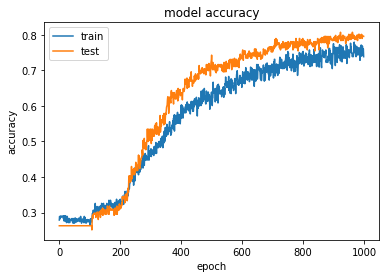

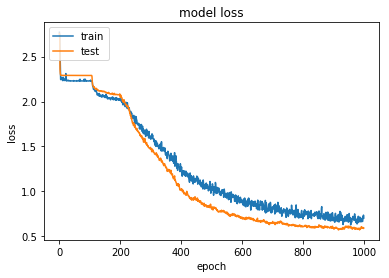

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()